In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from sklearn.utils import class_weight

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

def normalize_image(ima):
    return (ima - np.min(ima))/(np.max(ima) - np.min(ima))

In [3]:
from PIL import Image
from vis.visualization import visualize_cam

In [4]:
def add_brightness(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [5]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
# We'll extract features at the final pool layer.
model = Model(
    inputs=cnn_base.input,
    outputs=cnn_base.get_layer('fc2').output
)
def extract_image(image_path,model):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        return x
def vgg_model(x):
    features = model.predict(x)
    return features

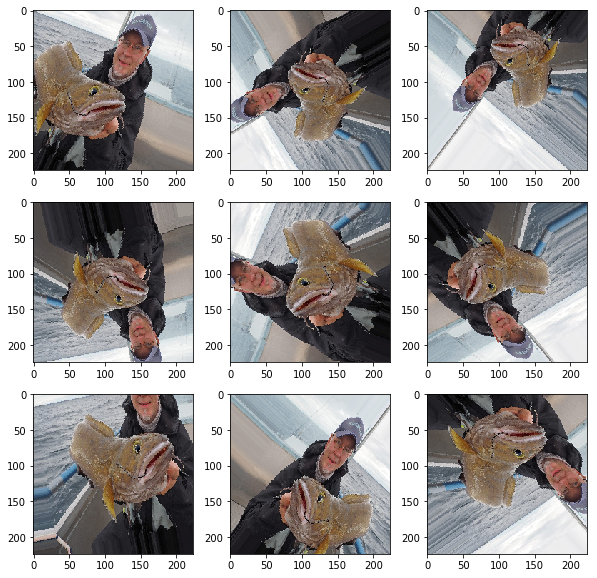

In [6]:
datagen = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2
    )
from keras.preprocessing import image
img = image.load_img("images/kusk fish/41. 4b2875f367758fea698bda68320fd43c.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

fig = plt.figure(figsize=(10,10))
i = 1
images_list = []
for X_batch in datagen.flow(normalize_image(x)):
    for imag in X_batch:
        images_list.append(imag)
    i = i + 1
    if i>10:
        break
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images_list[i])

In [7]:
datagen = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    #rescale=(1.0/255)
    #preprocessing_function=add_brightness
    )

In [8]:
labels = []
image_features = []

labels_test = []
image_features_test = []

images = []
image_count = 0
for idx,label in enumerate(os.listdir("images")):
    listdir = np.array(os.listdir("images/"+label))
    print(label,len(listdir))
    batch_sz = 100
    features = []
    labs = []
    label_batches = []
    
    labs_test = []
    label_batches_test = []
    count = 0
    for file in listdir:
        try:
            path = "images/"+label+'/'+file
            features.append(np.array(extract_image(path,model)[0]))
        except:
            count = count + 1
    print("Count is",count)
    temp_features = np.array(features)
    print(temp_features.shape)
    print("Done processing features")
    for i in range(int(len(listdir)/batch_sz)):
        X_features = temp_features[i*batch_sz:i*batch_sz+batch_sz]
        X_train, X_test, _, _ = train_test_split(X_features,np.ones(batch_sz,dtype='int'),test_size=0.1,random_state=1000)
        times = 0
        for X_batch in datagen.flow(X_train,batch_size=batch_sz):
                for aug_image in X_batch:
                    aug_image = preprocess_input(aug_image)
                    transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
                    label_batches.append(transformed_features)
                    labs.append(label)
                times = times + 1
                if times>1:
                    break
        for aug_image in X_train:
            aug_image = preprocess_input(aug_image)
            transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
            label_batches.append(transformed_features)
            labs.append(label)
        for aug_image in X_test:
            images.append(aug_image)
            aug_image = preprocess_input(aug_image)
            transformed_features = vgg_model(np.expand_dims(aug_image, axis=0))
            label_batches_test.append(transformed_features)
            labs_test.append(label)
        
    image_features = image_features + label_batches
    labels = labels + labs

    image_features_test = image_features_test + label_batches_test
    labels_test = labels_test + labs_test
    print(len(image_features_test))
    print(len(images))

cod caught 717
Count is 0
(717, 224, 224, 3)
Done processing features
70
70
out of water halibut 611
Count is 2
(609, 224, 224, 3)
Done processing features
130
130
kusk fish 351


/home/parmeet/anaconda3/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Count is 0
(351, 224, 224, 3)
Done processing features
160
160
fresh caught jonah crab 420
Count is 0
(420, 224, 224, 3)
Done processing features
200
200
caught lobster 573
Count is 0
(573, 224, 224, 3)
Done processing features
250
250


In [9]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)

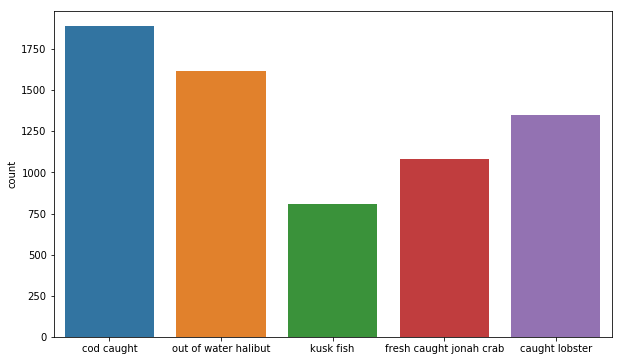

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(labels)

In [11]:
num_labels = len(np.unique(labels))

In [12]:
image_f = np.squeeze(np.array(image_features),axis=1)
image_f_test = np.squeeze(np.array(image_features_test),axis=1)

In [13]:
num_of_train_examples = image_f.shape
print(num_of_train_examples)
num_of_test_examples = image_f_test.shape
print(num_of_test_examples)

(6750, 4096)
(250, 4096)


In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [15]:
le.fit(list(labels)+list(labels_test))
#le.fit(list(labels))
le_labels = le.transform(labels)
le_labels_test = le.transform(labels_test)
one = preprocessing.OneHotEncoder()
#one.fit(list(le_labels.reshape(-1,1)))
one.fit(list(le_labels.reshape(-1,1))+list(le_labels_test.reshape(-1,1)))
one_labels = one.transform(le_labels.reshape(-1,1))
one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [16]:
image_f_test.shape

(250, 4096)

In [17]:
image_input = Input(shape=(4096,))
img_input = BatchNormalization()(image_input)
img_input = Dense(2048,activation='relu')(img_input)
img_input = BatchNormalization()(image_input)
output = Dense(num_labels,activation='softmax')(img_input)
model_dense = Model(image_input, output)
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_dense.save_weights('vgg-augmentation.hd5')

In [18]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1000)
test_cvscores = []
validation_cvscores = []
fusion_model_info = []
for train, test in kf.split(image_f):
    model_dense.load_weights('vgg-augmentation.hd5')
    hist = model_dense.fit(image_f[train], one_labels[train], epochs=10, verbose=1,class_weight=class_weights)
    print(hist.history['loss'])
    validation_score = model_dense.evaluate(image_f[test], one_labels[test], verbose=0)
    test_score = model_dense.evaluate(image_f_test, one_labels_test, verbose=0)
    predictions = model_dense.predict(image_f_test, verbose=0)
    predictions_validation = model_dense.predict(image_f[test], verbose=0)
    fusion_model_info.append([predictions_validation,one_labels[test],predictions,one_labels_test])
    pred_labels = np.argmax(predictions,axis=1)
    predicted_labels = le.inverse_transform(pred_labels)
    #print(labels[test])
    test_cvscores.append(test_score)
    validation_cvscores.append(validation_score)

Epoch 1/10
5400/5400 [==============================] - 1s 124us/step - loss: 0.8329 - acc: 0.7052
Epoch 2/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.4755 - acc: 0.8243
Epoch 3/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.3444 - acc: 0.8754
Epoch 4/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.2833 - acc: 0.8967
Epoch 5/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.2348 - acc: 0.9100
Epoch 6/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1922 - acc: 0.9304
Epoch 7/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1634 - acc: 0.9433
Epoch 8/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1409 - acc: 0.9507
Epoch 9/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1391 - acc: 0.9472
Epoch 10/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.1305 - acc: 0.9507
[0.832947

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 104us/step - loss: 0.9482 - acc: 0.7063
Epoch 2/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.4576 - acc: 0.8328
Epoch 3/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.3327 - acc: 0.8789
Epoch 4/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.2358 - acc: 0.9133
Epoch 5/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1869 - acc: 0.9330
Epoch 6/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1709 - acc: 0.9354
Epoch 7/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1479 - acc: 0.9459
Epoch 8/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.1389 - acc: 0.9507
Epoch 9/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1276 - acc: 0.9524
Epoch 10/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1237 - acc: 0.9587
[0.9482189307389436,

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 104us/step - loss: 0.9500 - acc: 0.7196
Epoch 2/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.4781 - acc: 0.8307
Epoch 3/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.3345 - acc: 0.8735
Epoch 4/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.2488 - acc: 0.9059
Epoch 5/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1920 - acc: 0.9270
Epoch 6/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1721 - acc: 0.9385
Epoch 7/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1474 - acc: 0.9459
Epoch 8/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.1297 - acc: 0.9528
Epoch 9/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1306 - acc: 0.9506
Epoch 10/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1204 - acc: 0.9596
[0.9499888345047279,

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 105us/step - loss: 0.9203 - acc: 0.7148
Epoch 2/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.4732 - acc: 0.8317
Epoch 3/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.3209 - acc: 0.8785
Epoch 4/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.2355 - acc: 0.9106
Epoch 5/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1964 - acc: 0.9231
Epoch 6/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1701 - acc: 0.9374
Epoch 7/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1519 - acc: 0.9420
Epoch 8/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1301 - acc: 0.9530
Epoch 9/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1216 - acc: 0.9541
Epoch 10/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.1029 - acc: 0.9669
[0.9203118922533813,

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 104us/step - loss: 0.9664 - acc: 0.7119
Epoch 2/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.4864 - acc: 0.8300
Epoch 3/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.3348 - acc: 0.8757
Epoch 4/10
5400/5400 [==============================] - 1s 115us/step - loss: 0.2470 - acc: 0.9067
Epoch 5/10
5400/5400 [==============================] - 1s 104us/step - loss: 0.2028 - acc: 0.9220
Epoch 6/10
5400/5400 [==============================] - 1s 103us/step - loss: 0.1658 - acc: 0.9443
Epoch 7/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1492 - acc: 0.9467
Epoch 8/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1353 - acc: 0.9515
Epoch 9/10
5400/5400 [==============================] - 1s 105us/step - loss: 0.1276 - acc: 0.9524
Epoch 10/10
5400/5400 [==============================] - 1s 113us/step - loss: 0.1169 - acc: 0.9569
[0.9664019669426812,

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
print(np.mean(np.array(test_cvscores)[:,1]))
print(np.std(np.array(test_cvscores)[:,1]))

print(np.mean(np.array(validation_cvscores)[:,1]))
print(np.std(np.array(validation_cvscores)[:,1]))

with open("vgg.pckl","wb") as vgg:
    pickle.dump(fusion_model_info,vgg)

0.7784000003814697
0.014880859641603286
0.7962962962433144
0.01189805806949533


In [20]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(np.array(test_cvscores)[:,1]*100)

[76.00 76.40 80.00 78.80 78.00]


In [21]:
#print("Validation Standard Deviation",np.std(validation_cvscores))
print("Test Standard Deviation",np.std(test_cvscores))

Test Standard Deviation 0.09164299817876424


In [22]:
with open("vgg.pckl","rb") as vgg:
    a = pickle.load(vgg)

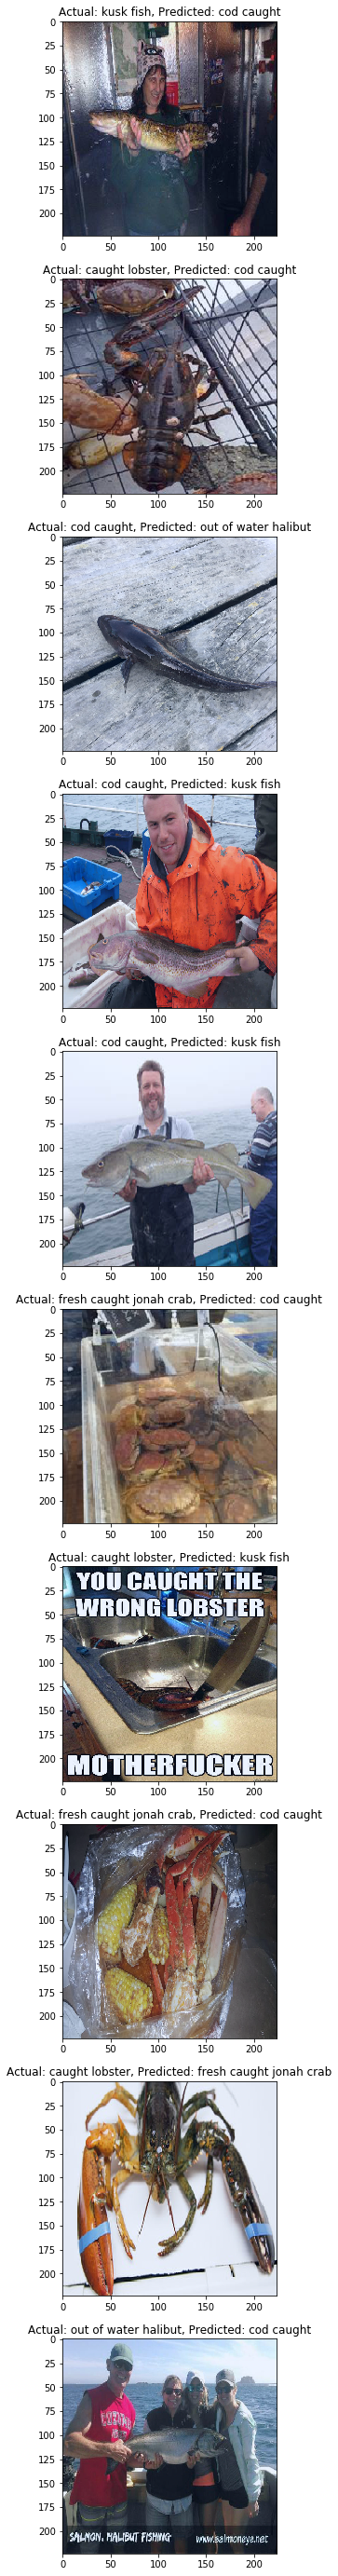

In [44]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = labels_test!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+labels_test[i]+', Predicted: '+predicted_labels[i])
plt.show()

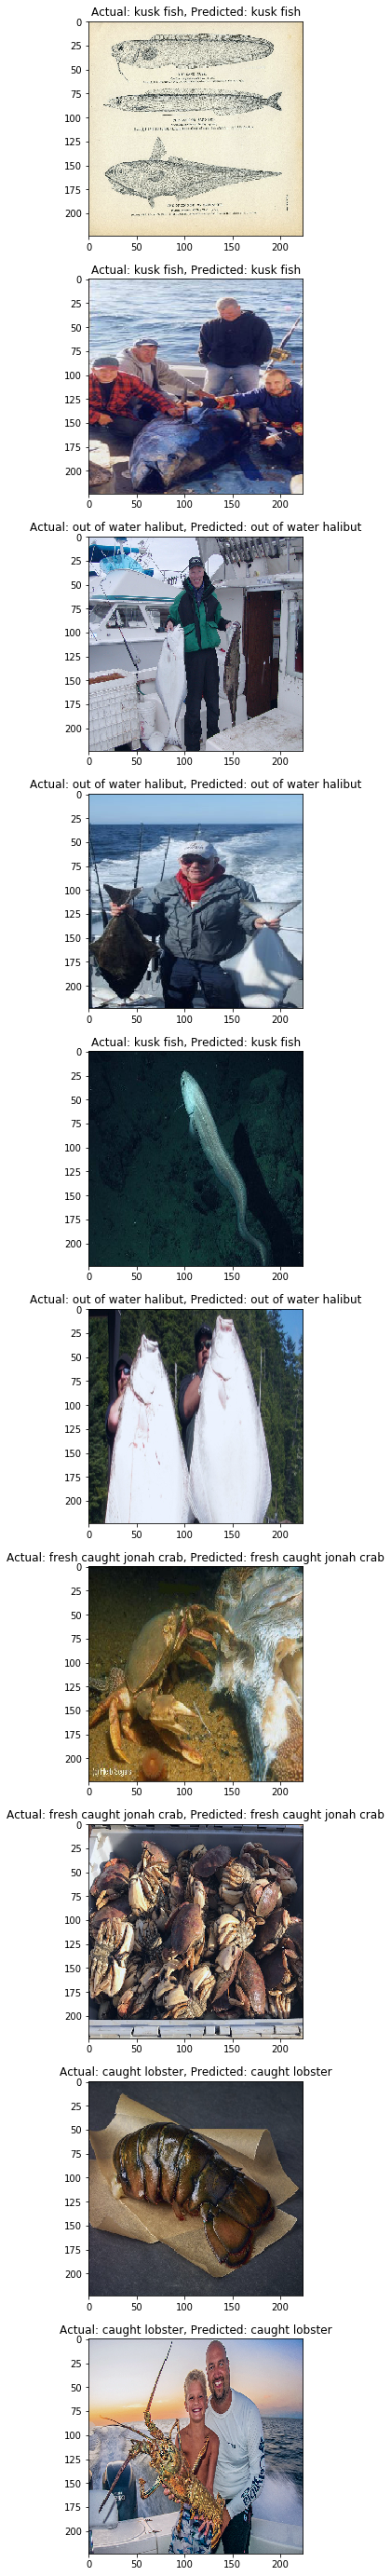

In [24]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    #ima = images[test[np.array(labels)[test]==predicted_labels][0]]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
    #print("Actual Label",np.array(labels)[test[eq_idx_list[i]]])
    #print("Predicted Label",predicted_labels[eq_idx_list[i]])
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix

[[40  0  6  2  2]
 [ 1 48  1 11  9]
 [ 3  1 34  1  1]
 [ 1  3  0 25  1]
 [ 0 13  0  2 45]]


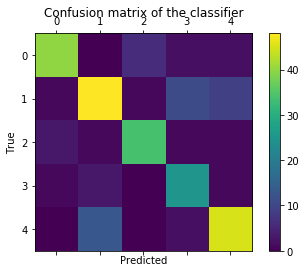

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, predicted_labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()